In [1]:
from __future__ import division
import os
import sys
import pandas as pd
import numpy as np


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
matplotlib.rc('ytick', labelsize=20) 
matplotlib.rc('xtick', labelsize=20) 

### Define helper functions
Just some basic tools that'll be helpful throughout the analysis

In [4]:
# tools for translating between 2D and 1D position indices for the calibration grid
calibGridDims = [5,5]
def getPtIdx(x,y):
    ptIdx = ((y-1)*calibGridDims[0]) + x
    return ptIdx

def getRowIdx(ptIdx):
    print ptIdx
    row,col = np.unravel_index(ptIdx-1, (calibGridDims[0],calibGridDims[1]))
    row = row+1
    col = col+1
    return row, col


In [5]:
# convert between cartesian and polar coordinates
def polar2cart(dist, angle):
    x = dist * np.cos(np.deg2rad(angle))
    y = dist * np.sin(np.deg2rad(angle))
    return x,y

In [6]:
# base plot for accuracy plotting
def plotCalibration(calibPts, figTitle):
    """
    calibPts is a dictionary, where each key holds another dictionary with fields for
    distance, angle, RMS, and color for a desired calibration pt. 
    """
    
    # start figure
    fig = plt.figure(figsize=(8,8))
    fig.suptitle(figTitle, fontsize=20, fontweight='bold')
    ax = fig.add_subplot(111)
    xRange = yRange = [-3.5, 3.5]
    ax.set_ylim(yRange[0], yRange[1])
    ax.set_xlim(xRange[0], xRange[1])

    # add circle at center for reference
    centerPt = plt.Circle((0,0), radius=.3, color='k', alpha=.4)
    ax.add_artist(centerPt)
    
    ax.spines['left'].set_position('center')
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks([])

    ax.spines['bottom'].set_position('center')
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks([])

    # Add circles as tickmarks
    for r in range(1,4):
        circle1 = plt.Circle((0,0), r, color='k', fill=False, ls=':', alpha=.6)
        ax.add_artist(circle1)

    # add cross lines
    lineExtent = 2.75
    ax.plot([-lineExtent, lineExtent], [-lineExtent, lineExtent], ls=':', color='k')
    ax.plot([-lineExtent, lineExtent], [lineExtent, -lineExtent], ls=':', color='k')

    # add labels
    ax.text(xRange[1]+.1, 0, '0$^\circ$ ', fontsize=15, verticalalignment='center', horizontalalignment='left')
    ax.text(lineExtent+.1, lineExtent+.1, '45$^\circ$ ', fontsize=15, horizontalalignment='left')
    ax.text(0, yRange[1]+.1, '90$^\circ$ ', fontsize=15, horizontalalignment='center')
    ax.text(-lineExtent-.1, lineExtent+.1, '135$^\circ$ ', fontsize=15, horizontalalignment='right')
    ax.text(xRange[0]-.1, 0, '180$^\circ$ ', fontsize=15, verticalalignment='center', horizontalalignment='right')
    ax.text(-lineExtent, -lineExtent-.1, '225$^\circ$ ', fontsize=15, horizontalalignment='right')
    ax.text(0, yRange[0]-.1, '270$^\circ$ ', fontsize=15, verticalalignment='top', horizontalalignment='center')
    ax.text(lineExtent+.1, -lineExtent-.1, '315$^\circ$ ', fontsize=15, horizontalalignment='left')

    for i in range(1,4):
        ax.text(np.cos(np.deg2rad(45))*i + .15, 
                np.sin(np.deg2rad(45))*i - .1, 
                str(i) + '$^\circ$ ', 
                fontsize=15,
                weight='bold',
                horizontalalignment='left')
        
    ####################### Plot the datapoints
    legHandles = []
    legLabels = []
    for i,ptKey in enumerate(calibPts.keys()):
        thisPt = calibPts[ptKey]
        dist = thisPt['dist']
        angle = thisPt['angle']
        rms = thisPt['RMS']
        ptColor = thisPt['color']
        
        # convert distance, angle to x,y 
        x,y = polar2cart(dist, angle)
        
        # plot the location
        loc = plt.Circle((x,y), .1, color=ptColor, label=ptKey)
        
        # plot the rms
        spread = plt.Circle((x,y), rms, facecolor=ptColor, edgecolor='none', alpha=.4)
        
        ax.add_artist(loc)
        ax.add_artist(spread)
        
        # add this point to the legend
        legHandles.append(loc)
        legLabels.append(ptKey)
    
    ### display legend
    # sort the data by label names
    legHandles, legLabels = (list(x) for x in zip(*sorted(zip(legHandles, legLabels), key=lambda x: x[1])))
    ax.legend(legHandles, legLabels, bbox_to_anchor=(1.3, 1))

## Load/Prep Data

In [7]:
# read in combined subjects dataframe
df = pd.read_csv('allConds_uniqueSubjs.csv', sep='\t')

In [8]:
df.head()

,RMS,centAngle,centDist,centX,centY,percentValid,ptIdx,condition,subj,offset
0,0.67,271.72,1.65,341.60,1108.90,1.00,22,e_0deg,e,0deg
1,0.42,295.66,2.22,660.21,833.53,0.94,13,e_0deg,e,0deg
2,0.58,285.25,2.71,785.50,602.52,0.96,4,e_0deg,e,0deg
3,0.61,313.76,2.34,436.32,614.94,1.00,6,e_0deg,e,0deg
4,0.16,284.53,2.58,274.73,1083.69,0.98,16,e_0deg,e,0deg


### convert condition labels cols to categorical dtype
This will create columns with unique codes for each subject, and unique codes for each condition

In [9]:
# convert to categorical dtype
df['subjCode'] = df.loc[:,'subj'].astype('category')
df['offsetCode'] = df.loc[:,'offset'].astype('category')

# show the numbers instead of labels
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

In [10]:
df.head()

,RMS,centAngle,centDist,centX,centY,percentValid,ptIdx,condition,subj,offset,subjCode,offsetCode
0,0.67,271.72,1.65,341.60,1108.90,1.00,22,e_0deg,e,0deg,0,0
1,0.42,295.66,2.22,660.21,833.53,0.94,13,e_0deg,e,0deg,0,0
2,0.58,285.25,2.71,785.50,602.52,0.96,4,e_0deg,e,0deg,0,0
3,0.61,313.76,2.34,436.32,614.94,1.00,6,e_0deg,e,0deg,0,0
4,0.16,284.53,2.58,274.73,1083.69,0.98,16,e_0deg,e,0deg,0,0


### remove invalid trials from the dataset

In [11]:
print df.shape
dfClean = df[df.percentValid >= .8]
print dfClean.shape

(525, 12)
(508, 12)


# Analyze Calibration Accuracy at 0deg offset
How accurately do the gaze points map on to the calibration grid locations when the grid is positioned directly in front of the participant

In [12]:
# grab the 0-deg offset trials
df_0deg = dfClean.loc[dfClean.offsetCode==0, :]

In [13]:
df_0deg.head()

,RMS,centAngle,centDist,centX,centY,percentValid,ptIdx,condition,subj,offset,subjCode,offsetCode
0,0.67,271.72,1.65,341.60,1108.90,1.00,22,e_0deg,e,0deg,0,0
1,0.42,295.66,2.22,660.21,833.53,0.94,13,e_0deg,e,0deg,0,0
2,0.58,285.25,2.71,785.50,602.52,0.96,4,e_0deg,e,0deg,0,0
3,0.61,313.76,2.34,436.32,614.94,1.00,6,e_0deg,e,0deg,0,0
4,0.16,284.53,2.58,274.73,1083.69,0.98,16,e_0deg,e,0deg,0,0


Calculate an overall mean across all calibration points for each subject

In [14]:
subj_mean = df_0deg.groupby('subjCode').mean()
subj_sem = df_0deg.groupby('subjCode').sem()

In [15]:
subj_sem

,RMS,centAngle,centDist,centX,centY,condition,offset,offsetCode,percentValid,ptIdx,subj
subjCode,,,,,,,,,,,
0,0.067435,2.866142,0.097225,40.240846,38.961296,NaN,NaN,0.0,0.004744,1.47196,NaN
1,0.053304,1.654441,0.059228,46.078114,41.683077,NaN,NaN,0.0,0.009569,1.47196,NaN
2,0.067567,8.439920,0.076529,45.961235,51.688067,NaN,NaN,0.0,0.009614,1.47196,NaN


### Plot each subject's mean at 0-deg offset

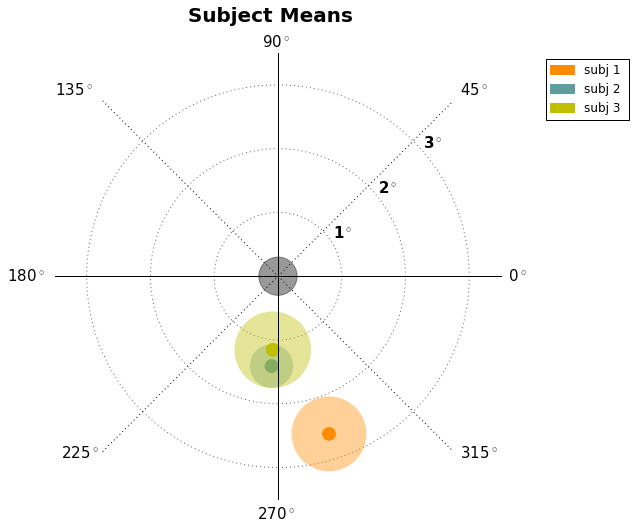

In [16]:
pts = {'subj 1': {'dist':subj_mean.loc[0, 'centDist'], 
                      'angle': subj_mean.loc[0, 'centAngle'], 
                      'RMS': subj_mean.loc[0, 'RMS'], 
                      'color':'darkorange'},
      'subj 2': {'dist':subj_mean.loc[1, 'centDist'], 
                      'angle': subj_mean.loc[1, 'centAngle'], 
                      'RMS': subj_mean.loc[1, 'RMS'], 
                      'color':'cadetblue'},
      'subj 3 ': {'dist':subj_mean.loc[2, 'centDist'], 
                      'angle': subj_mean.loc[2, 'centAngle'], 
                      'RMS': subj_mean.loc[2, 'RMS'], 
                      'color':'y'}}
plotCalibration(pts, 'Subject Means')

Calculate the group mean and standard error

In [31]:
group_mean = subj_mean.mean()
group_sem = subj_mean.sem()
group_mean

RMS               0.509867
centAngle       273.264933
centDist          1.722400
centX           524.584800
centY           771.182267
percentValid      0.956000
ptIdx            13.000000
offsetCode        0.000000
dtype: float64

### Plot the group mean at 0-deg offset

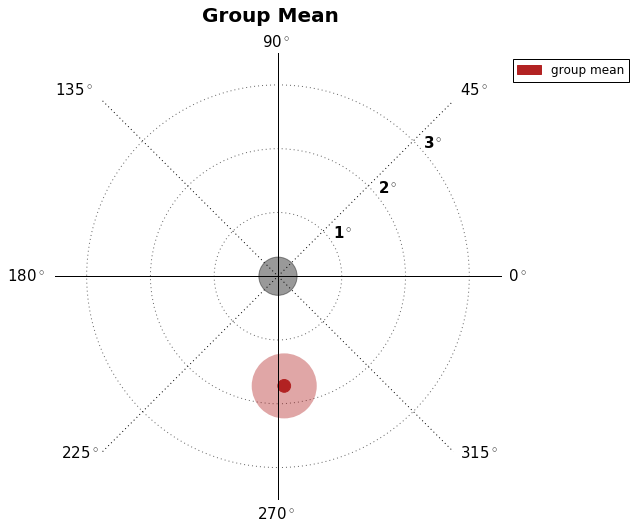

In [18]:
# gather the datapts into a dictionary to submit to the plotting function
pts = {'group mean': {'dist':group_mean.centDist, 
                      'angle': group_mean.centAngle, 
                      'RMS': group_mean.RMS, 
                      'color':'firebrick'}}
plotCalibration(pts, 'Group Mean')

## Are all 25 calibration pts necessary? Compare group mean w/ 25 pts vs 9 pts

In [19]:
# Figure out the ptIdx locations for the 9 calibration points 
ptIndices_set9 = []
for y in [1,3,5]:
    for x in [1,3,5]:
        ptIndices_set9.append(getPtIdx(x,y))
print ptIndices_set9
        

[1, 3, 5, 11, 13, 15, 21, 23, 25]


In [20]:
# create new dataframe from only the pt indices of the 9-calibration pts
df_0deg_calib25 = df_0deg.copy()
df_0deg_calib9 = df_0deg_calib25.loc[[x in ptIndices_set9 for x in df_0deg_calib25.ptIdx], :]

In [30]:
# calculate the mean by subject
subj_mean_calib9 = df_0deg_calib9.groupby('subjCode').mean()
subj_mean_calib9

,RMS,centAngle,centDist,centX,centY,percentValid,ptIdx,offsetCode
subjCode,,,,,,,,
0,0.432222,292.568889,2.711111,660.522222,895.824444,0.977778,13,0
1,0.301111,263.273333,1.423333,475.088889,734.553333,0.953333,13,0
2,0.426667,257.862222,1.214444,459.835556,697.223333,0.937778,13,0


In [29]:
# calculate the group mean over all subjects
group_mean_calib9 = subj_mean_calib9.mean()
group_mean_calib9

RMS               0.386667
centAngle       271.234815
centDist          1.782963
centX           531.815556
centY           775.867037
percentValid      0.956296
ptIdx            13.000000
offsetCode        0.000000
dtype: float64

### Plot mean accuracy and RMS with 25pts vs 9pts

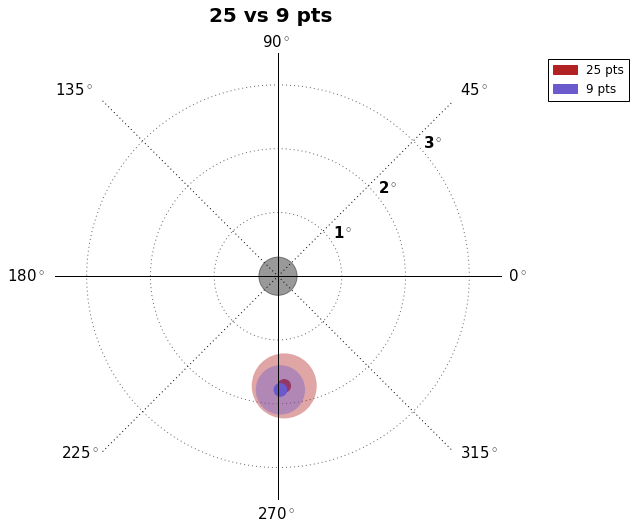

In [23]:
pts = {'25 pts': {'dist':group_mean.centDist, 
                      'angle': group_mean.centAngle, 
                      'RMS': group_mean.RMS, 
                      'color':'firebrick'},
      '9 pts': {'dist':group_mean_calib9.centDist, 
                      'angle': group_mean_calib9.centAngle, 
                      'RMS': group_mean_calib9.RMS, 
                      'color':'slateblue'}}
plotCalibration(pts, '25 vs 9 pts')

In [24]:
# create a new dataframe with mean results from 25pts vs 9pts; show
mean_25vs9pts = pd.concat([group_mean.iloc[:-2], group_mean_calib9.iloc[:-2]], axis=1, ignore_index=True).T
mean_25vs9pts.index = ['25 pts', '9 pts']
mean_25vs9pts

,RMS,centAngle,centDist,centX,centY,percentValid
25 pts,0.509867,273.264933,1.722400,524.584800,771.182267,0.956000
9 pts,0.386667,271.234815,1.782963,531.815556,775.867037,0.956296


# Accuracy and Precision at varying degrees of offset
How is accuracy and precision affected when the calibration grid is located +/- 15 degress off from center

In [25]:
# calculate the mean for every subject by offset condition
subjMeanByOffset = dfClean.groupby(['offsetCode', 'subjCode']).mean()
subjMeanByOffset

RMS   centAngle  centDist       centX       centY  \
offsetCode subjCode                                                           
0          0         0.587600  287.932400  2.598800  629.916400  899.728400   
           1         0.340000  265.918000  1.412000  484.222800  732.502400   
           2         0.602000  265.944400  1.156400  459.615200  681.316000   
1          0         0.860435  304.762609  2.288696  733.367826  806.218261   
           1         0.172000  320.306400  1.144400  640.747600  622.665200   
           2         0.898400  327.728800  1.044800  467.245200  579.978800   
2          0         0.643913  279.250435  2.582174  539.248696  915.916522   
           1         0.673750  254.438333  0.729167  424.572500  587.525417   
           2         0.682800  269.136400  1.857200  482.341600  792.570000   
3          0         1.463200  325.764000  1.519600  657.036800  638.960400   
           1         0.206000  345.786000  0.557600  567.419200  536.914800   
           2         1.404783  320.154783  1.608261  407.388261  582.227826   
4          0         1.000455  262.309545  2.008636  456.560455  841.788182   
           1         1.015652  281.558696  1.186957  519.439130  653.727826   
           2         0.731304  261.863913  1.020000  468.412609  635.928696   
5          0         0.757600  317.842400  1.024800  556.008400  616.095600   
           1         0.420000  298.426000  0.866400  565.484000  623.624000   
           2         0.971364  289.843636  1.149545  400.314545  591.517727   
6          0         0.490800  282.216000  2.784400  591.896400  952.385200   
           1         0.326000  265.379600  0.956800  483.658000  648.541200   
           2         0.539200  330.132000  0.724400  552.320800  563.898800   

                     percentValid      ptIdx  
offsetCode subjCode                           
0          0             0.967200  13.000000  
           1             0.963200  13.000000  
           2             0.937600  13.000000  
1          0             0.920000  12.956522  
           1             0.996800  13.000000  
           2             0.962400  13.000000  
2          0             0.962609  12.608696  
           1             0.910000  13.208333  
           2             0.966400  13.000000  
3          0             0.890400  13.000000  
           1             0.994400  13.000000  
           2             0.931304  12.956522  
4          0             0.941818  13.727273  
           1             0.954783  13.565217  
           2             0.942609  12.434783  
5          0             0.960000  13.000000  
           1             0.959200  13.000000  
           2             0.905455  12.863636  
6          0             0.959200  13.000000  
           1             0.978400  13.000000  
           2             0.955200  13.000000

In [26]:
# group according to each offset code and take the mean across all subjects within that condition
offSetMeans = subjMeanByOffset.groupby(level='offsetCode').mean()
offSetMeans

,RMS,centAngle,centDist,centX,centY,percentValid,ptIdx
offsetCode,,,,,,,
0,0.509867,273.264933,1.722400,524.584800,771.182267,0.956000,13.000000
1,0.643612,317.599270,1.492632,613.786875,669.620754,0.959733,12.985507
2,0.666821,267.608389,1.722847,482.054265,765.337313,0.946336,12.939010
3,1.024661,330.568261,1.228487,543.948087,586.034342,0.938701,12.985507
4,0.915804,268.577385,1.405198,481.470731,710.481568,0.946403,13.242424
5,0.716321,302.037345,1.013582,507.268982,610.412442,0.941552,12.954545
6,0.452000,292.575867,1.488533,542.625067,721.608400,0.964267,13.000000


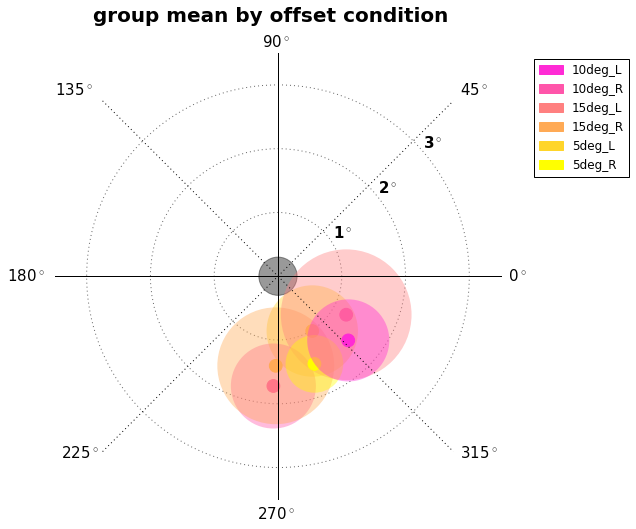

In [34]:
# Loop through all each offset code (skipping 0), add results to dictionary
cmap = plt.get_cmap('spring', offSetMeans.shape[0])
pts = {}
for i in range(1, offSetMeans.shape[0]):
    # get the offset code name
    offset_name = dfClean.loc[dfClean.offsetCode == i, 'offset'].iloc[0]
    
    # get the values from this offset code
    dist = offSetMeans.loc[i].centDist
    angle = offSetMeans.loc[i].centAngle
    rms = offSetMeans.loc[i].RMS
    c = cmap(i)
    
    # build dictionary entry
    pts[offset_name] = {'dist': dist, 'angle': angle, 'RMS': rms, 'color': c}

# plot the calibration points
plotCalibration(pts, 'group mean by offset condition')
    